# Homework 2

**The following notebook is meant to help you work through Problems 1 and 3 on Homework 2. You are by no means required to use it, nor are you required to fill out/use any of the boilerplate code/functions. You are welcome to implement the functions however you wish.**


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as c
import matplotlib.patches as mpatches
from scipy.special import expit as sigmoid
from scipy.special import softmax
from scipy.special import logsumexp
from scipy.spatial.distance import cdist

In [2]:
# loading data

# data for Problem 1
t_obs, y_obs = np.genfromtxt("data/planet-obs.csv", delimiter = ',').T
t_obs = np.split(t_obs, 10)
y_obs = np.split(y_obs.reshape(-1, 1), 10)

# data for Problem 3
data = pd.read_csv("data/hr.csv")
mapper = {
    "Dwarf": 0,
    "Giant": 1,
    "Supergiant": 2
}
data['Type'] = data['Type'].map(mapper)

X_stars = data[['Magnitude', 'Temperature']].values
y_stars = data['Type'].values

from T2_P1_TestCases import test_p1
from T2_P3_TestCases import test_p3_softmax, test_p3_knn

# Problem 1

## Problem 1 Subpart 1

In [3]:
def basis1(t):
    return np.stack([np.ones(len(t)), t], axis=1)

def basis2(t):
    """
    Transform t into basis [1, t, t^2]

    :param t: a 1D numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 3)
    """
    # TODO
    return np.stack([np.ones(len(t)), t, t**2], axis=1)
    

def basis3(t):
    """
    Transform t into basis [1, t, t^2, t^3, t^4, t^5]

    :param t: a numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 6)
    """
    # TODO
    return np.stack([np.ones(len(t)), t, t**2, t**3, t**4, t**5], axis=1)

In [8]:
class LogisticRegressor:
    def __init__(self, eta, runs):
        self.eta = eta
        self.runs = runs
        self.W = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, x, y, w_init):
        """
        Optimize the weights W to minimize the negative log-likelihood by using gradient descent

        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :param y: a 2D numpy array of output values. Shape is (n x 1)
        :param w_init: a 2D numpy array that initializes the weights. Shape is (d x 1), where d is the number of dimensions of transformed feature values. 
        :return: None
        """
        # Keep this for the autograder
        self.W = w_init
        # TODO
        for _ in range(self.runs):
            z = np.dot(x, self.W)
            predictions = self.sigmoid(z)
            errors = predictions - y
            gradient = np.dot(x.T, errors) / len(x)
            self.W -= self.eta * gradient
    
    def predict(self, x):
        """
        Predict classification probability of transformed input x
        
        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :return: a 2D numpy array of predicted probabilities given current weights. Shape should be (n x 1)
        """
        # TODO
        z = np.dot(x, self.W)
        return self.sigmoid(z)

In [5]:
test_p1(LogisticRegressor, basis1, basis2, basis3)

1.372916588054823
Your test case results are, for basis 1, 2, and 3 respectively: Pass Pass Fail


/var/folders/z_/z80nfr_11pb4k54vwnh48y_h0000gp/T/ipykernel_71188/486891602.py:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Note: Students have reported local issues with passing the basis 3 test case. Try running on Google Colab if only basis 3 test is failing.  

## Plotting Functions for Problem 1, Subpart 2

In [6]:
# Function to visualize prediction lines
# Takes as input last_x, last_y, [list of models], basis function, title
# last_x and last_y should specifically be the dataset that the last model
# in [list of models] was trained on
def visualize_prediction_lines(last_x, last_y, models, basis, title):
    # Plot setup
    green = mpatches.Patch(color='green', label='Ground truth model')
    black = mpatches.Patch(color='black', label='Mean of learned models')
    purple = mpatches.Patch(color='purple', label='Model learned from displayed dataset')
    plt.legend(handles=[green, black, purple], loc='lower right')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Observed')
    plt.axis([0, 6, -.1, 1.1]) # Plot ranges

    # Plot dataset that last model in models (models[-1]) was trained on
    cmap = c.ListedColormap(['r', 'b'])
    plt.scatter(last_x, last_y, c=last_y, cmap=cmap, linewidths=1, edgecolors='black')

    # Plot models
    X_pred = np.linspace(0, 6, 1000)
    X_pred_transformed = basis(X_pred)

    ## Ground truth model
    plt.plot(X_pred, np.cos(1.1*X_pred + 1) * 0.4 + 0.5, 'g', linewidth=5)

    ## Individual learned logistic regressor models
    Y_hats = []
    for i in range(len(models)):
        model = models[i]
        Y_hat = model.predict(X_pred_transformed)
        Y_hats.append(Y_hat)
        if i < len(models) - 1:
            plt.plot(X_pred, Y_hat, linewidth=.3)
        else:
            plt.plot(X_pred, Y_hat, 'purple', linewidth=3)

    # Mean / expectation of learned models over all datasets
    plt.plot(X_pred, np.mean(Y_hats, axis=0), 'k', linewidth=5)

    plt.savefig(title + '.png')
    plt.show()

In [7]:
# You may find it helpful to modify this function for Problem 1, Subpart 4,
# but do not change the existing code--add your own variables
def plot_results(basis, title):
    eta = 0.001
    runs = 10000

    all_models = []
    for i in range(10):
        x, y = t_obs[i], y_obs[i]
        x_transformed = basis(x)
        model = LogisticRegressor(eta=eta, runs=runs)
        model.fit(x_transformed, y, np.zeros((x_transformed.shape[1], 1)))
        all_models.append(model)

    visualize_prediction_lines(x, y, all_models, basis, title)

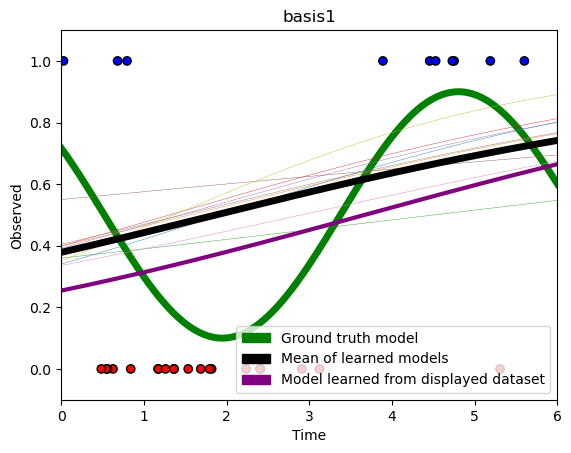

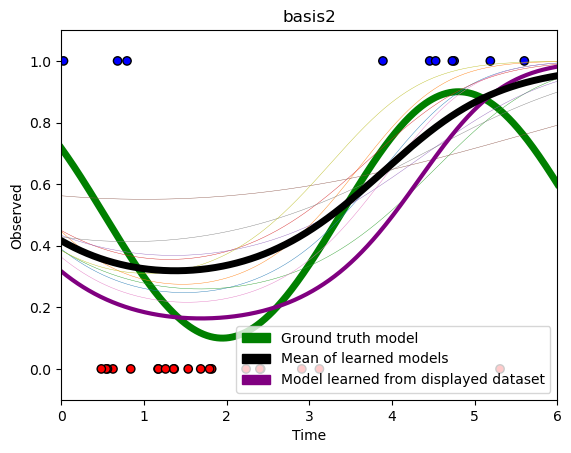

/var/folders/z_/z80nfr_11pb4k54vwnh48y_h0000gp/T/ipykernel_46463/486891602.py:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


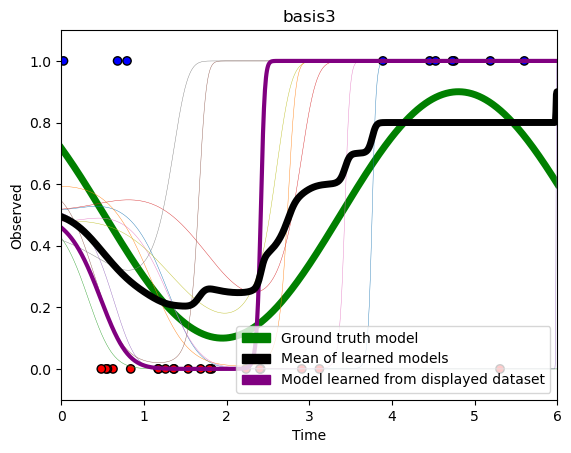

In [11]:
plot_results(basis1, 'basis1')
plot_results(basis2, 'basis2')
plot_results(basis3, 'basis3')

In [10]:
#Qeustion 4
t_points = np.array([0.1, 3.2])

# Transform the points
t_transformed = basis3(t_points)

print("Transformed points:", t_transformed)

# Assuming t_obs and y_obs have been defined as in your notebook snippet
# We only need the first set of data points (first 30 data points)
x_first, y_first = t_obs[0], y_obs[0]

# Transform the first dataset using basis3
x_first_transformed = basis3(x_first)

# Initialize the first logistic regression model
eta = 0.001  # Learning rate
runs = 10000  # Number of gradient descent iterations
first_model = LogisticRegressor(eta=eta, runs=runs)

# Train the first model using the transformed first dataset
w_init = np.zeros((x_first_transformed.shape[1], 1))  # Initialize weights as zeros
first_model.fit(x_first_transformed, y_first, w_init)

# Now, predict with the first model using transformed points for t = 0.1 and t = 3.2
# Assuming t_transformed has been computed using basis3, as shown previously
probabilities = first_model.predict(t_transformed)

# Print out the predicted probabilities for t = 0.1 and t = 3.2
print("Predicted probabilities at t = 0.1 and t = 3.2:", probabilities.squeeze())

# Initialize an array to store predicted probabilities for each model
predicted_probabilities = np.zeros((10, 2))  # 10 models, 2 points (t = 0.1 and t = 3.2)

# Loop over each of the 10 datasets
for i in range(10):
    # Select the dataset
    x, y = t_obs[i], y_obs[i]
    
    # Transform the dataset using basis3
    x_transformed = basis3(x)
    
    # Initialize and train the logistic regression model
    model = LogisticRegressor(eta=0.001, runs=10000)
    model.fit(x_transformed, y, np.zeros((x_transformed.shape[1], 1)))
    
    # Predict the classification probabilities for t = 0.1 and t = 3.2
    predicted_probabilities[i] = model.predict(t_transformed).squeeze()

# Compute the variance of the predicted probabilities for each point
variance_at_t = np.var(predicted_probabilities, axis=0)

# Output the results
print("Predicted probabilities for all models at t = 0.1 and t = 3.2:\n", predicted_probabilities)
print("Variance of predicted probabilities at t = 0.1 and t = 3.2:", variance_at_t)


Transformed points: [[1.0000000e+00 1.0000000e-01 1.0000000e-02 1.0000000e-03 1.0000000e-04
  1.0000000e-05]
 [1.0000000e+00 3.2000000e+00 1.0240000e+01 3.2768000e+01 1.0485760e+02
  3.3554432e+02]]
Predicted probabilities at t = 0.1 and t = 3.2: [5.19492501e-01 7.12392698e-06]


/var/folders/z_/z80nfr_11pb4k54vwnh48y_h0000gp/T/ipykernel_71188/486891602.py:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Predicted probabilities for all models at t = 0.1 and t = 3.2:
 [[5.19492501e-01 7.12392698e-06]
 [5.91369108e-01 9.99999921e-01]
 [3.80851585e-01 6.23238197e-07]
 [5.21384304e-01 9.87291389e-01]
 [4.92957688e-01 2.19284366e-56]
 [5.08489939e-01 1.00000000e+00]
 [4.80378779e-01 4.02293426e-03]
 [4.07741335e-01 1.00000000e+00]
 [4.80957071e-01 9.99987166e-01]
 [4.31452498e-01 1.00000000e+00]]
Variance of predicted probabilities at t = 0.1 and t = 3.2: [0.00340419 0.23851561]


# Problem 3

In [38]:
class GaussianGenerativeModel:
    def __init__(self, is_shared_covariance=False):
        self.is_shared_covariance = is_shared_covariance
        self.means = None
        self.cov = None
        self.priors = None

    def fit(self, X, y):
        """
        Compute the means and (shared) covariance matrix of the data. Compute the prior over y.
        
        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Dwarf=0, Giant=1, Supergiant=2).
        :return: None
        """
        classes = np.unique(y)
        num_classes = len(classes)
        num_features = X.shape[1]
        self.means = np.zeros((num_classes, num_features))
        self.cov = np.zeros((num_features, num_features)) if self.is_shared_covariance else np.zeros((num_classes, num_features, num_features))
        self.priors = np.zeros(num_classes)
        
        for idx, cls in enumerate(classes):
            X_cls = X[y == cls]
            self.means[idx, :] = np.mean(X_cls, axis=0)
            if self.is_shared_covariance:
                self.cov += np.cov(X_cls, rowvar=False) * (X_cls.shape[0] - 1)
            else:
                self.cov[idx] = np.cov(X_cls, rowvar=False)
            self.priors[idx] = X_cls.shape[0] / X.shape[0]
        
        if self.is_shared_covariance:
            self.cov /= (X.shape[0] - num_classes)


    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces 
        (currently meaningless) visualization.
        
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        inv_cov = np.linalg.inv(self.cov)
        likelihoods = []
        for idx in range(len(self.means)):
            mean = self.means[idx]
            prior = self.priors[idx]
            cov = self.cov if self.is_shared_covariance else self.cov[idx]
            inv_cov = np.linalg.inv(cov)
            diff = X_pred - mean
            likelihood = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
            likelihood += np.log(prior)
            likelihoods.append(likelihood)
        likelihoods = np.array(likelihoods).T
        return np.argmax(likelihoods, axis=1)

    def negative_log_likelihood(self, X, y):
        """
        Given the data X, use previously calculated class means and covariance matrix to 
        calculate the negative log likelihood of the data
        """
        n = X.shape[0]
        K = len(np.unique(y))  # Number of classes
        NLL = 0  # Initializing Negative Log Likelihood
        
        # Loop over each class
        for k in range(K):
            # Select data points belonging to class k
            X_k = X[y == k]
            # Compute prior for class k
            prior_k = self.priors[k]
            # Compute density for class k
            if self.is_shared_covariance:
                cov_k = self.cov  # Shared covariance matrix
            else:
                cov_k = self.cov[k]  # Separate covariance matrix for each class
                
            # Calculate the log likelihood for each data point in class k
            rv = multivariate_normal(mean=self.means[k], cov=cov_k)
            for x in X_k:
                NLL -= np.log(rv.pdf(x) + 1e-6) + np.log(prior_k)  # Adding a small value to avoid log(0)

        return NLL

In [39]:
class SoftmaxRegression:
    def __init__(self, eta, lam):
        self.eta = eta
        self.lam = lam
        self.W = None

    def fit(self, X, y):
        """
        Fit the weights W of softmax regression using gradient descent with L2 regularization
        Use the results from Problem 2 to find an expression for the gradient
        
        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Dwarf=0, Giant=1, Supergiant=2).
        :return: None
        """
        # Initializing the weights (do not change!)
        # The number of classes is 1 + (the highest numbered class)
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        n_features = X.shape[1]
        self.means = np.zeros((n_classes, n_features))
        self.cov = np.zeros((n_features, n_features)) if self.is_shared_covariance else np.zeros((n_classes, n_features, n_features))
        self.priors = np.zeros(n_classes)
        
        for idx, cls in enumerate(self.classes):
            X_cls = X[y == cls]
            self.means[idx] = np.mean(X_cls, axis=0)
            self.priors[idx] = X_cls.shape[0] / X.shape[0]
            if self.is_shared_covariance:
                self.cov += np.cov(X_cls, rowvar=False) * (X_cls.shape[0] - 1)
            else:
                self.cov[idx] = np.cov(X_cls, rowvar=False)
        
        if self.is_shared_covariance:
            self.cov /= (X.shape[0] - n_classes)


    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.
        
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        inv_cov = np.linalg.inv(self.cov)
        likelihoods = np.zeros((X_pred.shape[0], len(self.classes)))
        for idx, cls in enumerate(self.classes):
            mean = self.means[idx]
            if self.is_shared_covariance:
                cov_det = np.linalg.det(self.cov)
                cov_inv = inv_cov
            else:
                cov_det = np.linalg.det(self.cov[idx])
                cov_inv = np.linalg.inv(self.cov[idx])
            diff = X_pred - mean
            likelihood = -0.5 * np.sum(diff.dot(cov_inv) * diff, axis=1)
            likelihood -= 0.5 * np.log(cov_det)
            likelihood += np.log(self.priors[idx])
            likelihoods[:, idx] = likelihood
        return np.argmax(likelihoods, axis=1)
    
    def predict_proba(self, X_pred):
        """    
        Predict classification probabilities of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 2D numpy array of predicted class probabilities (Dwarf=index 0, Giant=index 1, Supergiant=index 2).
                 Shape should be (n x 3)
        """
        nll = 0
        for idx, cls in enumerate(self.classes):
            X_cls = X[y == cls]
            mean = self.means[idx]
            cov = self.cov if self.is_shared_covariance else self.cov[idx]
            nll_cls = 0.5 * (np.log(np.linalg.det(cov)) + (X_cls - mean) @ np.linalg.inv(cov) @ (X_cls - mean).T - np.log(self.priors[idx]))
            nll += np.sum(nll_cls)
        return nll

In [40]:
class KNNClassifier:
    def __init__(self, k):
        self.X = None
        self.y = None
        self.K = k
        
    def fit(self, X, y):
        """
        In KNN, "fitting" can be as simple as storing the data, so this has been written for you.
        If you'd like to add some preprocessing here without changing the inputs, feel free,
        but this is completely optional.
        """
        self.X = X
        self.y = y

    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.
        
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        # TODO
        n_pred = X_pred.shape[0]
        n_train = self.X_train.shape[0]
        preds = np.zeros(n_pred, dtype=int)
        
        for i in range(n_pred):
            # Compute the distance from each point in X_pred to each point in self.X_train
            distances = np.sum(((self.X_train - X_pred[i]) / [3, 1]) ** 2, axis=1)
            # Find the indices of the k smallest distances
            nearest_indices = np.argsort(distances)[:self.k]
            # Get the labels of the k nearest neighbors
            nearest_labels = self.y_train[nearest_indices]
            # Predict the label by majority vote
            unique, counts = np.unique(nearest_labels, return_counts=True)
            preds[i] = unique[np.argmax(counts)]
        
        return preds

In [41]:
def phi(X):
    """
    Transform [x_1, x_2] into basis [ln(x_1 + 10), x_2^2]

    :param t: a 2D numpy array of values to transform. Shape is (n x 2)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 2)
    """
    return np.vstack([np.log(X[:, 0] + 10), X[:, 1]**2]).T

## Plotting Function for Problem 3, Subpart 1

In [42]:
# Visualize the decision boundary that a model produces
def visualize_boundary(model, X, y, title, basis=None, width=2):
    # Create a grid of points
    x_min, x_max = min(X[:, 0] - width), max(X[:, 0] + width)
    y_min, y_max = min(X[:, 1] - width), max(X[:, 1] + width)
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.05),
        np.arange(y_min, y_max, 0.05)
    )

    # Flatten the grid so the values match spec for self.predict
    xx_flat = xx.flatten()
    yy_flat = yy.flatten()
    X_pred = np.vstack((xx_flat, yy_flat)).T
    
    if basis is not None:
        X_pred = basis(X_pred)

    # Get the class predictions
    Y_hat = model.predict(X_pred)
    Y_hat = Y_hat.reshape((xx.shape[0], xx.shape[1]))

    # Visualize them.
    cmap = c.ListedColormap(['r', 'b', 'g'])
    plt.figure()
    plt.title(title)
    plt.xlabel('Magnitude')
    plt.ylabel('Temperature')
    plt.pcolormesh(xx, yy, Y_hat, cmap=cmap, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, linewidths=1,
                edgecolors='black')

    # Adding a legend and a title
    red = mpatches.Patch(color='red', label='Dwarf')
    blue = mpatches.Patch(color='blue', label='Giant')
    green = mpatches.Patch(color='green', label='Supergiant')
    plt.legend(handles=[red, blue, green])

    # Saving the image to a file, and showing it as well
    plt.savefig(title + '.png')
    plt.show()

## Problem 3, Subpart 1

In [49]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
softmax_model = SoftmaxRegression(eta=0.001, lam=0.001)
softmax_model.fit(X_stars, y_stars)
visualize_boundary(model=softmax_model,
                   X=X_stars,
                   y=y_stars,
                   title='softmax_regression_result',
                   basis=None)

AttributeError: 'SoftmaxRegression' object has no attribute 'is_shared_covariance'

In [19]:
# test your models by passing your fitted models into the functions below
# softmax_model is an instance of class SoftmaxRegression fitted to data X_stars, y_stars
# basis_model is an instance of class SoftmaxRegression fitted to data phi(X_stars), y_stars
# knn1_model is an instance of class KNNClassifier with parameter k=1
# knn5_model is an instance of class KNNClassifier with parameter k=5
test_p3_softmax(softmax_model, basis_model)
test_p3_knn(knn1_model, knn5_model)

NameError: name 'basis_model' is not defined